In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
    
SUB_FOLDER_PATH = "../input/kitchenware-classification/images/"

print("Tensorflow version:", tf.__version__)
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)

Tensorflow version: 2.6.4
numpy version: 1.21.6
pandas version: 1.3.5


# Introduction

### Files:
- train.csv - the training set (Image IDs and classes)
- test.csv - the test set (Just image IDs)
- sample_submission.csv - a sample submission file in the correct format
- images/ - the images in the JPEG format


# Load CSV

We will use ***ImageDataGenerator.flow_from_dataframe()*** from *Tensorflow* so, The "Id" column must be string. And dataframe has to have image names with extension like jpg.

In [2]:
# All train data
df = pd.read_csv("/kaggle/input/kitchenware-classification/train.csv")

# test data for competiton
df_test_competition = pd.read_csv("/kaggle/input/kitchenware-classification/test.csv")

# example submission file
df_submission = pd.read_csv("/kaggle/input/kitchenware-classification/sample_submission.csv")


# load the data with the targets
df = pd.read_csv('../input/kitchenware-classification/train.csv', dtype={'Id': str})
df['filename'] = df['Id'] + '.jpg'

df_test_competition = pd.read_csv('../input/kitchenware-classification/test.csv', dtype={'Id': str})
df_test_competition['filename'] =  df_test_competition['Id'] + '.jpg'

df_submission = pd.read_csv('../input/kitchenware-classification/sample_submission.csv', dtype={'Id': str})

In [3]:
df.head()

,Id,label,filename
0,0560,glass,0560.jpg
1,4675,cup,4675.jpg
2,0875,glass,0875.jpg
3,4436,spoon,4436.jpg
4,8265,plate,8265.jpg


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5559 entries, 0 to 5558
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        5559 non-null   object
 1   label     5559 non-null   object
 2   filename  5559 non-null   object
dtypes: object(3)
memory usage: 130.4+ KB


In [5]:
df_test_competition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        3808 non-null   object
 1   filename  3808 non-null   object
dtypes: object(2)
memory usage: 59.6+ KB


In [6]:
df_test_competition.head()

,Id,filename
0,0678,0678.jpg
1,3962,3962.jpg
2,9271,9271.jpg
3,5133,5133.jpg
4,8842,8842.jpg


In [7]:
df_test_competition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        3808 non-null   object
 1   filename  3808 non-null   object
dtypes: object(2)
memory usage: 59.6+ KB


In [8]:
df_submission.head()

,Id,label
0,0678,spoon
1,3962,glass
2,9271,spoon
3,5133,plate
4,8842,spoon


In [9]:
df_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      3808 non-null   object
 1   label   3808 non-null   object
dtypes: object(2)
memory usage: 59.6+ KB


# Split Data to Train, Validation and Test Data
- %60 Train
- %20 Validation
- %20 Test 

First we will split data and create simple model and evaluate.

In [10]:
# train and test data
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)

# split train to train and validation
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=42)

In [11]:
len_of_df = {"Train:": len(df_train), "Validation": len(df_val), "Test": len(df_test)}

len_of_df

{'Train:': 4502, 'Validation': 501, 'Test': 556}

In [12]:
len_of_df.values()

dict_values([4502, 501, 556])

In [13]:
len_of_df.keys()

dict_keys(['Train:', 'Validation', 'Test'])

In [14]:
def plot_percent_pie(df):
    """ plot percent of give dataframes
    Note that If we give numbers of df other than 3, it will give us an error.
    
    Args:
        len_of_df: a dictionary contains names and length of dataframes
    """
    colors = ["#645CBB","#A084DC", "#BFACE2"]
    explode = [0, 0.05, 0.05]
    
    classes = df.keys()
    numbers = df.values()
    
    print(df)
    
    plt.figure(figsize = (5,5))
    plt.pie(numbers, explode=explode, labels=classes, colors=colors, autopct='%1.1f%%')
    plt.title("Rates of Dataset Lengths", color = 'blue',fontsize = 14)

{'Train:': 4502, 'Validation': 501, 'Test': 556}


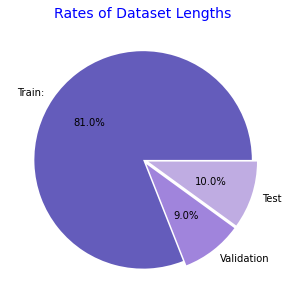

In [15]:
plot_percent_pie(len_of_df)

# Load Data - Preprocessing

In [16]:
df_train

,Id,label,filename
5213,3877,cup,3877.jpg
224,1988,fork,1988.jpg
3673,6755,spoon,6755.jpg
4402,8789,glass,8789.jpg
3811,3746,knife,3746.jpg
...,...,...,...
4134,6290,glass,6290.jpg
1319,5057,spoon,5057.jpg
850,6103,plate,6103.jpg
4506,6394,plate,6394.jpg


# Train Simple Model

In [17]:
width = 224
height = 224

number = 128
batch_size = number
val_batch_size = number
test_batch_size = number

epochs = 10

input_size = (width, height)
input_shape = (width, height, 3)

train_datagen = ImageDataGenerator(shear_range=10,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# column names for input and oupt
x_col = "filename"
y_col = "label"

train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                            directory=SUB_FOLDER_PATH,
                                            x_col= x_col,
                                            y_col= y_col,
                                            batch_size=batch_size,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=input_size)

validation_generator = val_datagen.flow_from_dataframe(dataframe=df_val,
                                            directory=SUB_FOLDER_PATH,
                                            x_col= x_col,
                                            y_col= y_col,
                                            batch_size=val_batch_size,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=input_size)

test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                            directory=SUB_FOLDER_PATH,
                                            x_col= x_col,
                                            y_col= y_col,
                                            batch_size=test_batch_size,
                                            seed=42,
                                            shuffle=False,
                                            class_mode="categorical",
                                            target_size=input_size)

submit_gen = ImageDataGenerator()
submit_generator = submit_gen.flow_from_dataframe(dataframe=df_test_competition,
                                                  directory=SUB_FOLDER_PATH,
                                                  x_col= x_col,
                                                  batch_size=test_batch_size,
                                                  seed=42,
                                                  shuffle=False,
                                                  class_mode=None,
                                                  target_size=input_size)

Found 4502 validated image filenames belonging to 6 classes.
Found 501 validated image filenames belonging to 6 classes.
Found 556 validated image filenames belonging to 6 classes.
Found 3808 validated image filenames.


In [18]:
resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                                   weights='imagenet',
                                                   input_shape=input_shape,
                                                   pooling=None)

resnet50.trainable = False

2023-01-31 23:23:44.013567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 23:23:44.109349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 23:23:44.110401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 23:23:44.112899: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 4s 0us/step


In [19]:
def build_model(input_shape=input_shape):

    inputs = keras.Input(shape=input_shape)
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = resnet50(x)
    x = layers.Flatten()(x)
    
    x = layers.Dense(64, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    drop = keras.layers.Dropout(0.1)(x)
    outputs = layers.Dense(6, activation="softmax")(drop)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    learning_rate = 0.001
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

In [20]:
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256   

In [21]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                patience=30,),
                 keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras",
                                                  monitor="val_loss",
                                                  save_best_only=True,)]

In [22]:
train_generator.reset()
validation_generator.reset()

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=epochs, 
                    callbacks=callbacks_list, 
                    batch_size=batch_size)

2023-01-31 23:23:56.313736: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-31 23:24:04.387228: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


36/36 [==============================] - 155s 4s/step - loss: 0.4013 - accuracy: 0.8625 - val_loss: 0.7787 - val_accuracy: 0.8623


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
36/36 [==============================] - 115s 3s/step - loss: 0.1746 - accuracy: 0.9445 - val_loss: 0.3413 - val_accuracy: 0.9022
Epoch 3/10
36/36 [==============================] - 111s 3s/step - loss: 0.1273 - accuracy: 0.9594 - val_loss: 0.3081 - val_accuracy: 0.9182
Epoch 4/10
36/36 [==============================] - 113s 3s/step - loss: 0.0898 - accuracy: 0.9749 - val_loss: 0.2642 - val_accuracy: 0.9281
Epoch 5/10
36/36 [==============================] - 116s 3s/step - loss: 0.0719 - accuracy: 0.9809 - val_loss: 0.2648 - val_accuracy: 0.9202
Epoch 6/10
36/36 [==============================] - 122s 3s/step - loss: 0.0598 - accuracy: 0.9822 - val_loss: 0.2583 - val_accuracy: 0.9242
Epoch 7/10
36/36 [==============================] - 118s 3s/step - loss: 0.0505 - accuracy: 0.9871 - val_loss: 0.2577 - val_accuracy: 0.9261
Epoch 8/10
36/36 [==============================] - 113s 3s/step - loss: 0.0449 - accuracy: 0.9873 - val_loss: 0.2568 - val_accuracy: 0.9301
Epoch 9/10
36

# Training Graphs

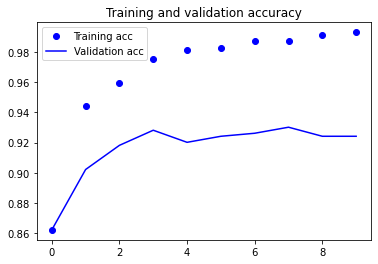

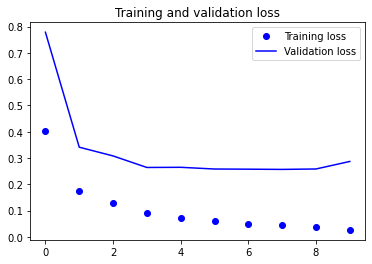

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Reload the best model

In [24]:
model = keras.models.load_model("checkpoint_path.keras")

# Save Model

In [25]:
MODEL_NAME = "resnet_model"
model.save(MODEL_NAME)

2023-01-31 23:44:28.515336: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Accuracy on Test Set

In [26]:
# evaluate
test_loss, test_accuracy = model.evaluate(test_generator)
print("test_loss: ", test_loss)
print("test_accuracy", test_accuracy)

# predict
test_generator.reset()
test_pred = model.predict(test_generator)

# Convert predictions classes to one hot vectors 
test_pred_classes = np.argmax(test_pred, axis = 1)

5/5 [==============================] - 11s 2s/step - loss: 0.1558 - accuracy: 0.9424
test_loss:  0.15575949847698212
test_accuracy 0.9424460530281067


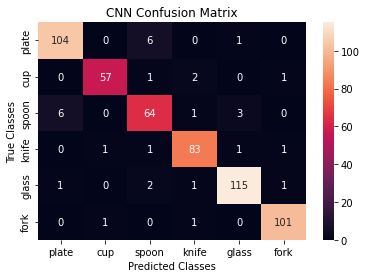

In [27]:
# confusion matrix

# compute the confusion matrix
confusion_mtx = confusion_matrix(test_generator.classes, test_pred_classes) 

CATEGORIES = ["plate", "cup", "spoon", "knife", "glass", "fork"]

# plot the confusion matrix
ax= plt.subplot()
sns.heatmap(confusion_mtx, annot=True, fmt="d") 
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.title("CNN Confusion Matrix")
ax.xaxis.set_ticklabels(CATEGORIES); ax.yaxis.set_ticklabels(CATEGORIES);
plt.show()

In [28]:
test_generator.class_indices

{'cup': 0, 'fork': 1, 'glass': 2, 'knife': 3, 'plate': 4, 'spoon': 5}

In [29]:
test_pred.shape

(556, 6)

### Converting Dictionary's keys and values

In [30]:
d = {'a': 1, 'b': 2, 'c': 3}

keys = d.keys()
values = d.values()

print(list(keys)) # ['a', 'b', 'c']
print(list(values)) # [1, 2, 3]

new_d = dict(zip(values,keys))

new_d

['a', 'b', 'c']
[1, 2, 3]


{1: 'a', 2: 'b', 3: 'c'}

In [31]:
# test_generator.class_indices

keys = test_generator.class_indices.keys()
values = test_generator.class_indices.values()

class_dict = dict(zip(values,keys))

class_dict

{0: 'cup', 1: 'fork', 2: 'glass', 3: 'knife', 4: 'plate', 5: 'spoon'}

In [32]:
def predict(output, class_dict):
    # Get the index of the highest value in the output tensor
    prediction_index = tf.argmax(output, axis=-1)
    
    # Use the index to look up the corresponding class or label in the class dictionary
    prediction_list = [class_dict[index.numpy()] for index in prediction_index]
    
    return prediction_list

# Submission

In [33]:
test_preds = model.predict(submit_generator)
test_preds

array([[5.4171987e-02, 5.6350213e-01, 4.0626476e-04, 1.8842436e-01,
        6.8583726e-03, 1.8663694e-01],
       [9.5521475e-09, 7.5803887e-06, 2.5467912e-07, 9.9999189e-01,
        6.7104160e-08, 1.5246489e-07],
       [1.0702986e-03, 9.5517898e-01, 1.4750877e-03, 3.8809653e-02,
        2.0985908e-04, 3.2561661e-03],
       ...,
       [3.5496960e-06, 5.0908067e-05, 4.9924267e-05, 5.7998170e-07,
        1.5870257e-06, 9.9989343e-01],
       [1.9725046e-06, 9.9944633e-01, 1.1190566e-04, 2.4908381e-05,
        7.2515274e-07, 4.1415743e-04],
       [9.2507726e-06, 4.7132056e-05, 1.0502016e-04, 1.9987319e-06,
        4.7274239e-06, 9.9983180e-01]], dtype=float32)

In [34]:
print(len(test_preds))

3808


In [35]:
test_predictions = predict(test_preds, class_dict)
print(type(test_predictions))

print(len(test_predictions))

<class 'list'>
3808


In [36]:
df_submission['label'] = test_predictions
df_submission

,Id,label
0,0678,fork
1,3962,knife
2,9271,fork
3,5133,plate
4,8842,fork
...,...,...
3803,7626,plate
3804,2052,cup
3805,8827,spoon
3806,2299,fork


In [37]:
df_submission.to_csv('submission.csv', index=False)